In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np

import scienceplots
import matplotlib.pyplot as plt
# plt.style.use(['science', 'nature', 'no-latex'])
#plt.style.use(['science', 'notebook', 'no-latex'])
%config InlineBackend.figure_formats = {'retina', 'png'}

from sklearn import metrics, preprocessing, pipeline, model_selection, linear_model
import pandas as pd
import xgboost as xgb
from prophet import Prophet
from sklearn_pandas import DataFrameMapper

from darts import TimeSeries
from darts.models import NBEATSModel, AutoARIMA
from darts.metrics import mape, r2_score
from darts.dataprocessing.transformers import MissingValuesFiller

/home/gcerar/miniconda3/envs/energy-graph/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:

def monthly_plot(data: pd.DataFrame, key:str, month:int, year:int, ax, vmin:float=None, vmax:float=None):
    data = data.set_index('timestamp')

    data = data[[key]].resample('1H').mean()
    
    new_index = pd.date_range(start=f'{data.index.year.min()}-01-01T00:00', end=f'{data.index.year.max()+1}-01-01T00:00', freq='1H')
    data = data.reindex(new_index)

    data = data[(data.index.year == year) & (data.index.month == month)]

    hour = data.index.hour
    day = data.index.day
    series = data[key]
    series = series.values.reshape(24, len(day.unique()), order="F")
    
    xgrid = np.arange(day.max() + 1) + 1
    ygrid = np.arange(25)
    
    ax.grid(False)

    ax.pcolormesh(xgrid, ygrid, series, cmap="magma", vmin=vmin, vmax=vmax)
    # Invert the vertical axis
    ax.set_ylim(24, 0)
    # Set tick positions for both axes
    ax.yaxis.set_ticks([i for i in range(24)])
    ax.xaxis.set_ticks([10, 20, 30])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.xaxis.set_tick_params(which='both', length=0)
    
    # Remove all spines
    ax.set_frame_on(False)

In [13]:
df = pd.read_parquet('../data/uciml-dataset-hourly.parquet')
df.head(7).T


timestamp,2006-12-16 17:00:00,2006-12-16 18:00:00,2006-12-16 19:00:00,2006-12-16 20:00:00,2006-12-16 21:00:00,2006-12-16 22:00:00,2006-12-16 23:00:00
global_active_power,70.381481,60.536667,56.670556,54.476111,50.941111,36.668889,34.36
global_reactive_power,3.816667,1.333889,1.420556,1.251667,1.277778,0.936111,1.190556
sub_metering_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sub_metering_2,0.527778,6.716667,1.433333,0.0,0.416667,0.133333,0.083333
sub_metering_3,16.861111,16.866667,16.683333,16.783333,17.216667,4.433333,0.0
unmetered,52.992593,36.953333,38.553889,37.692778,33.307778,32.102222,34.276667
voltage,234.643889,234.580167,233.2325,234.0715,237.158667,238.76,240.619667
global_intensity,18.1,15.6,14.503333,13.916667,13.046667,9.523333,8.896667
country,France,France,France,France,France,France,France
region,Sceaux,Sceaux,Sceaux,Sceaux,Sceaux,Sceaux,Sceaux


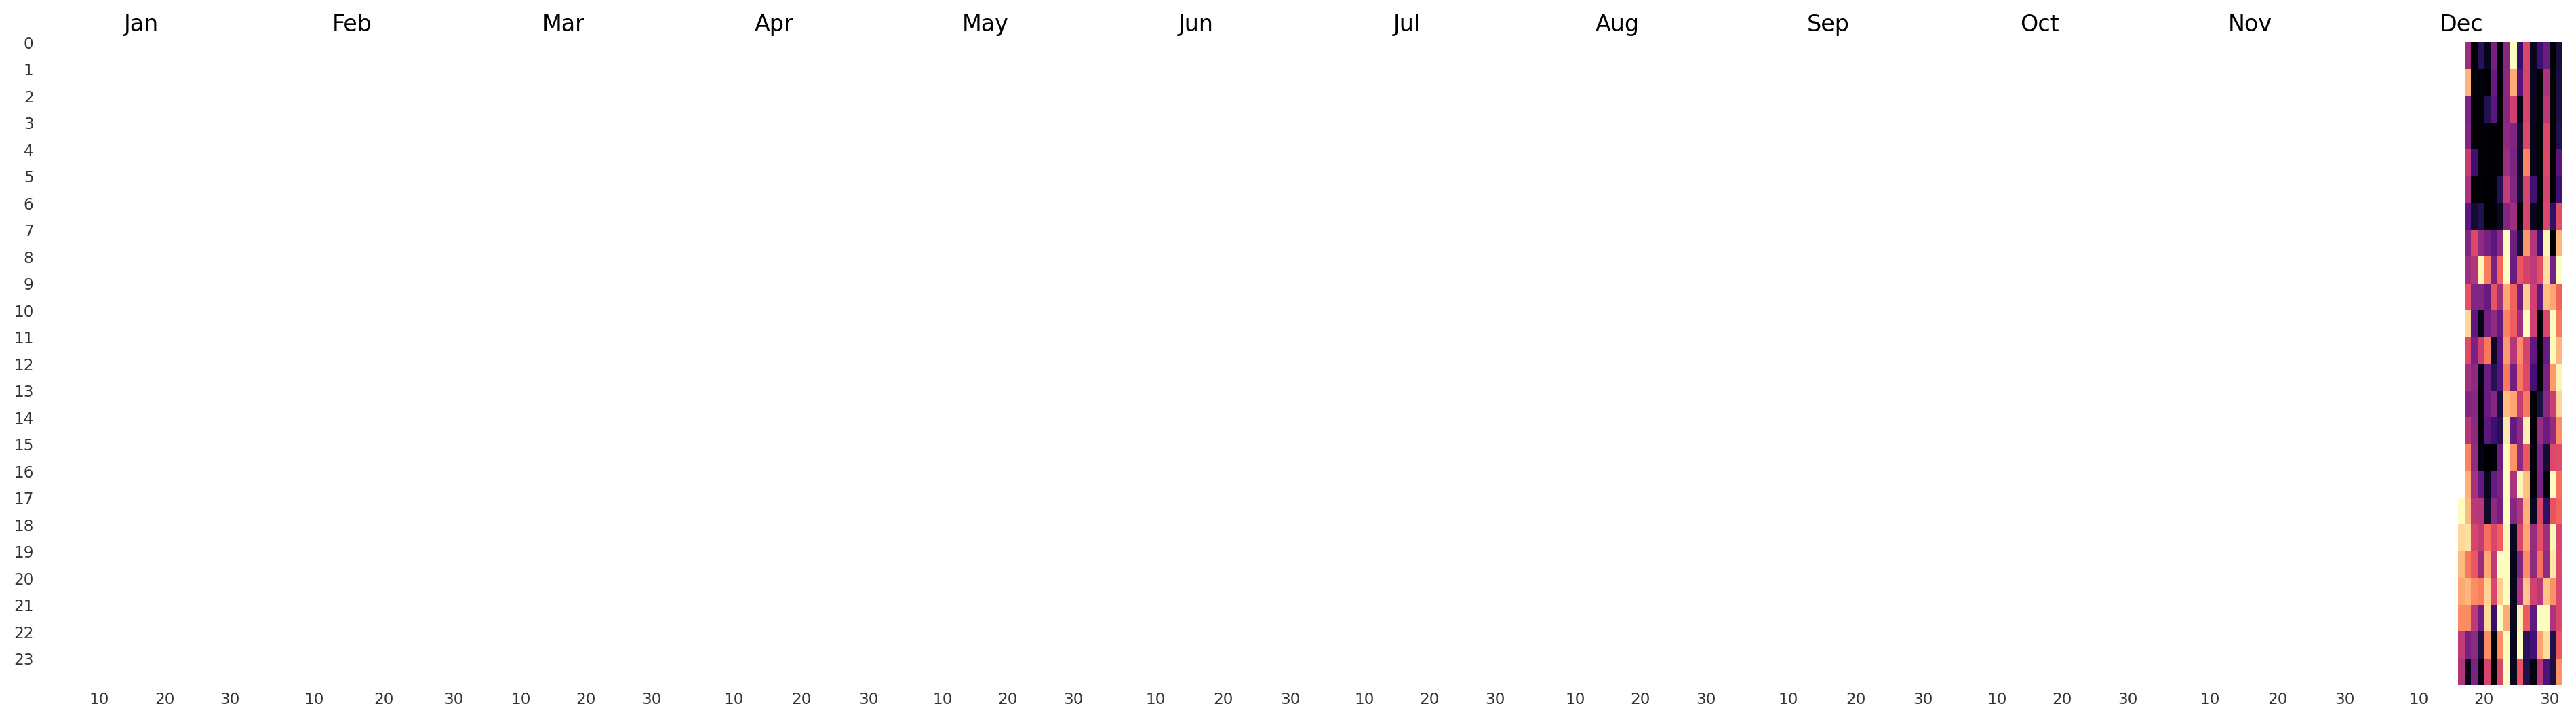

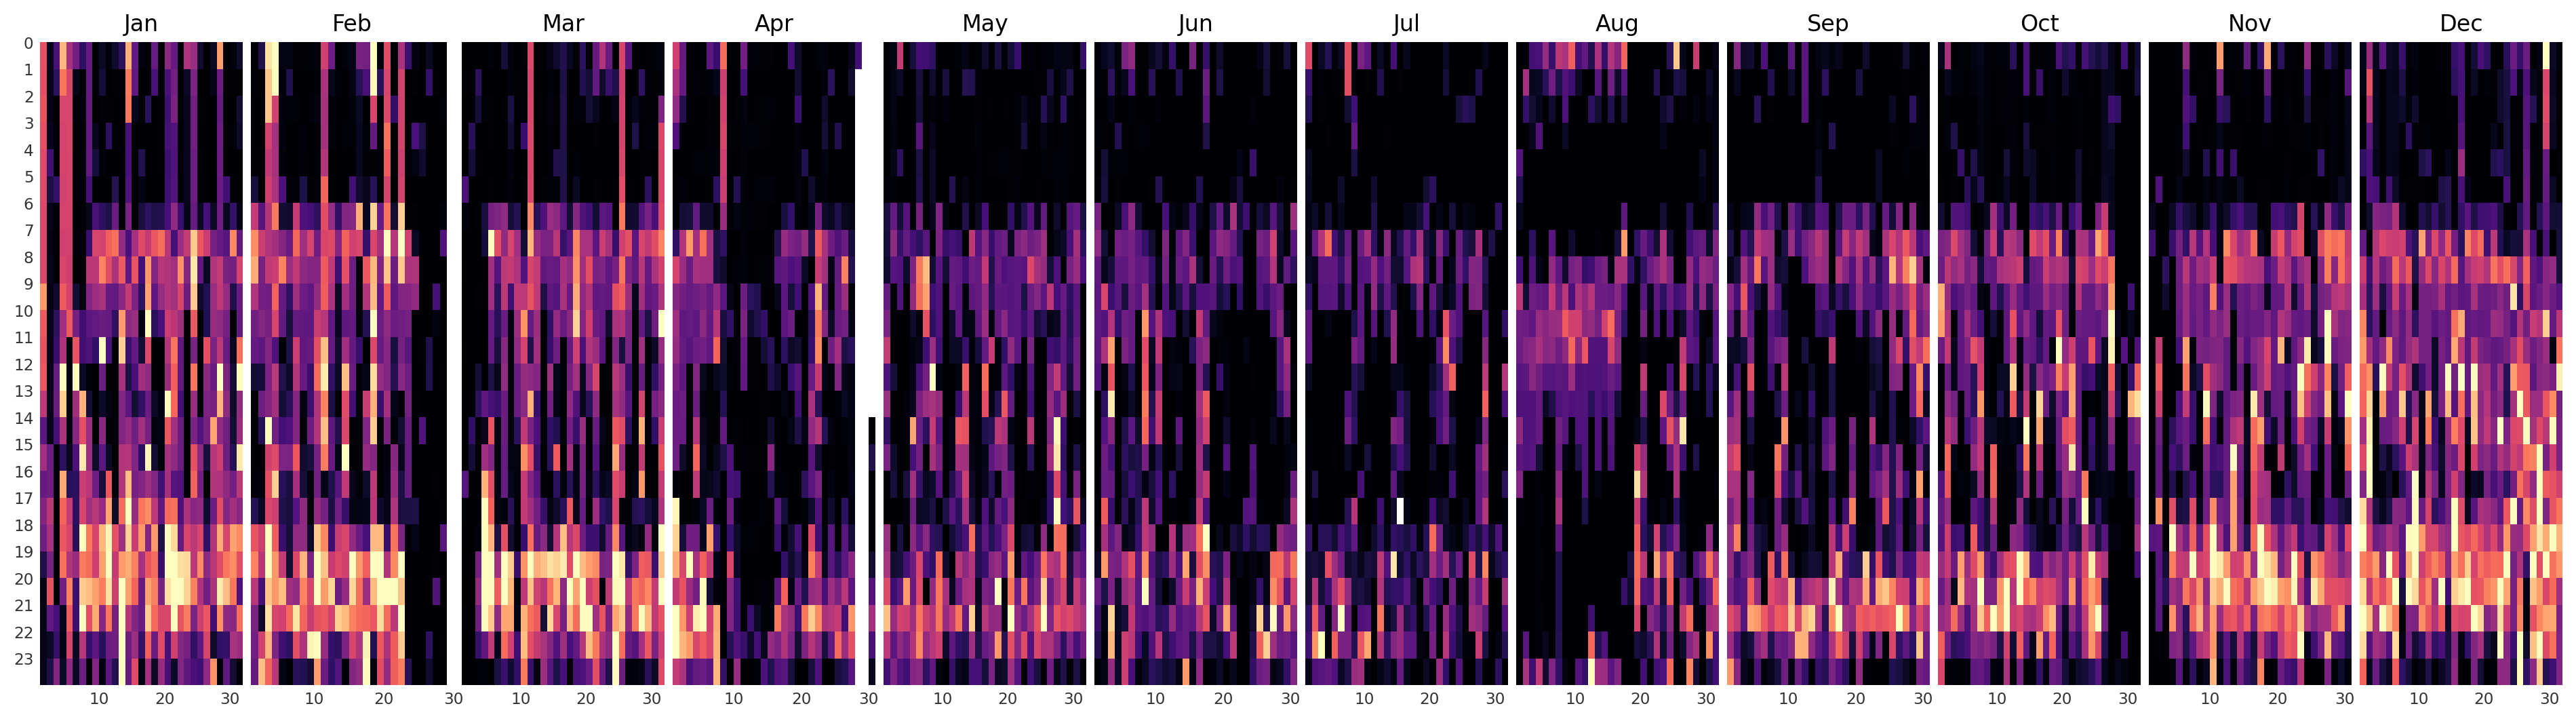

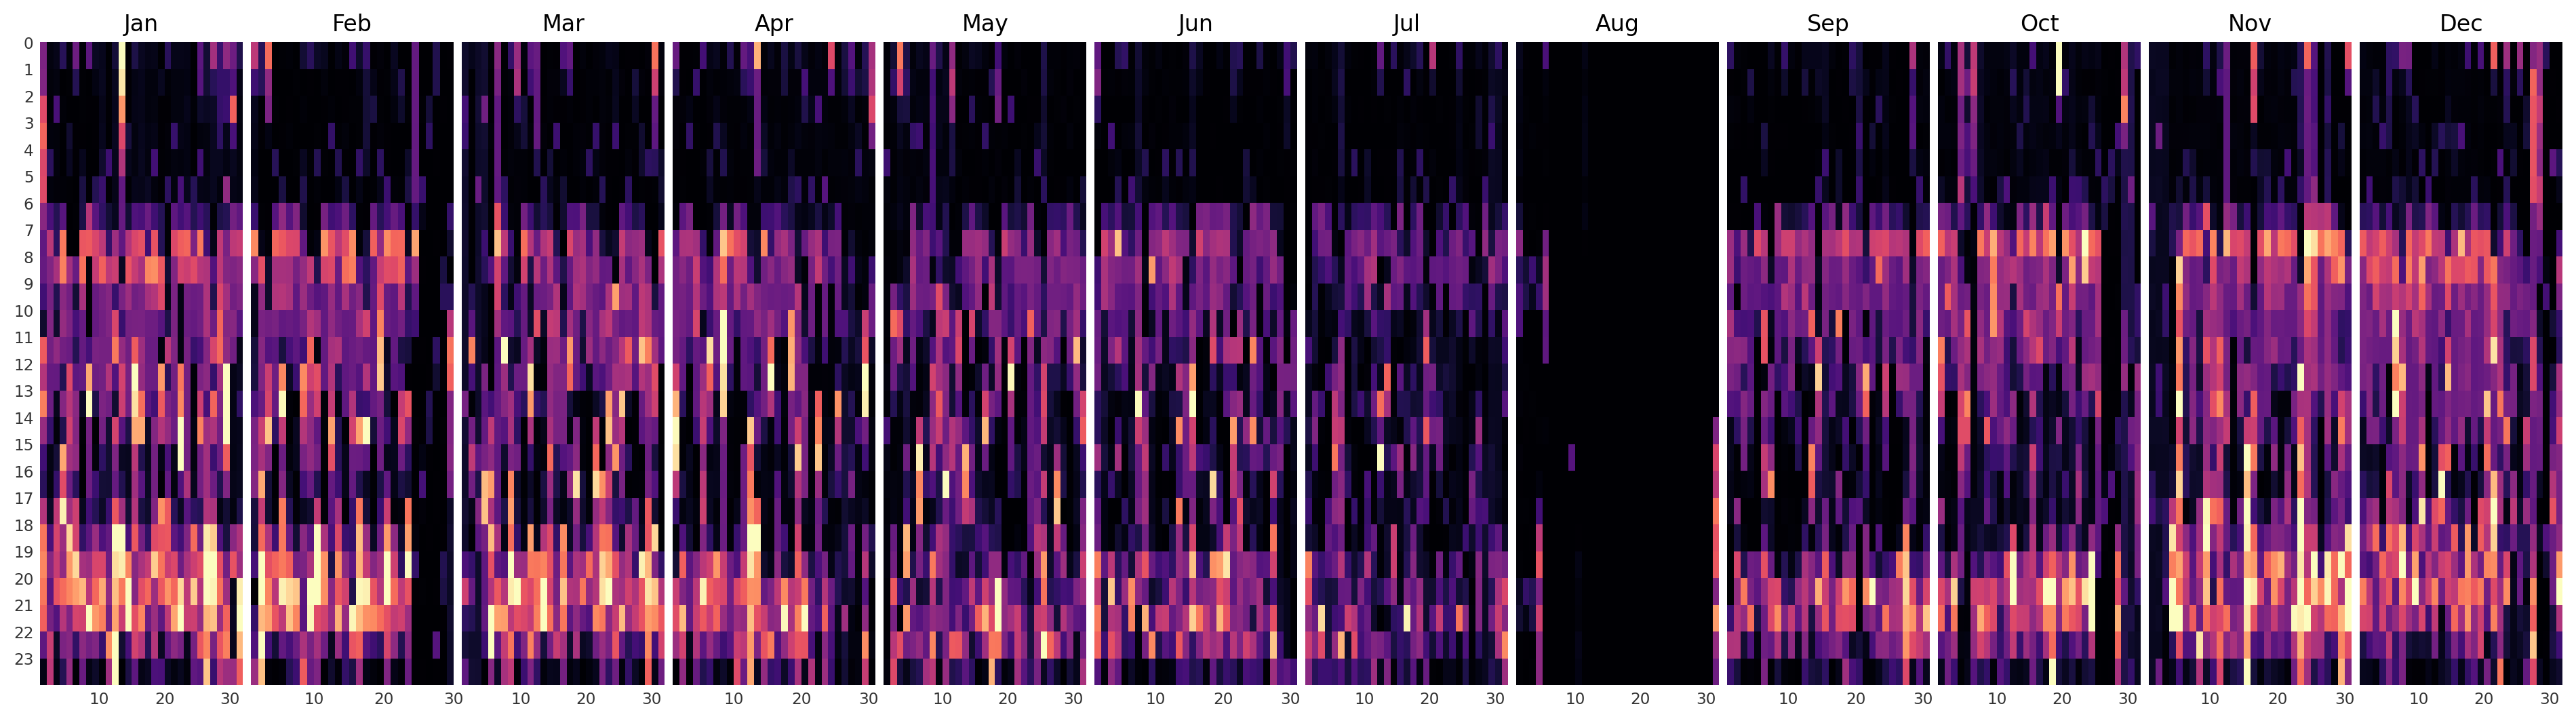

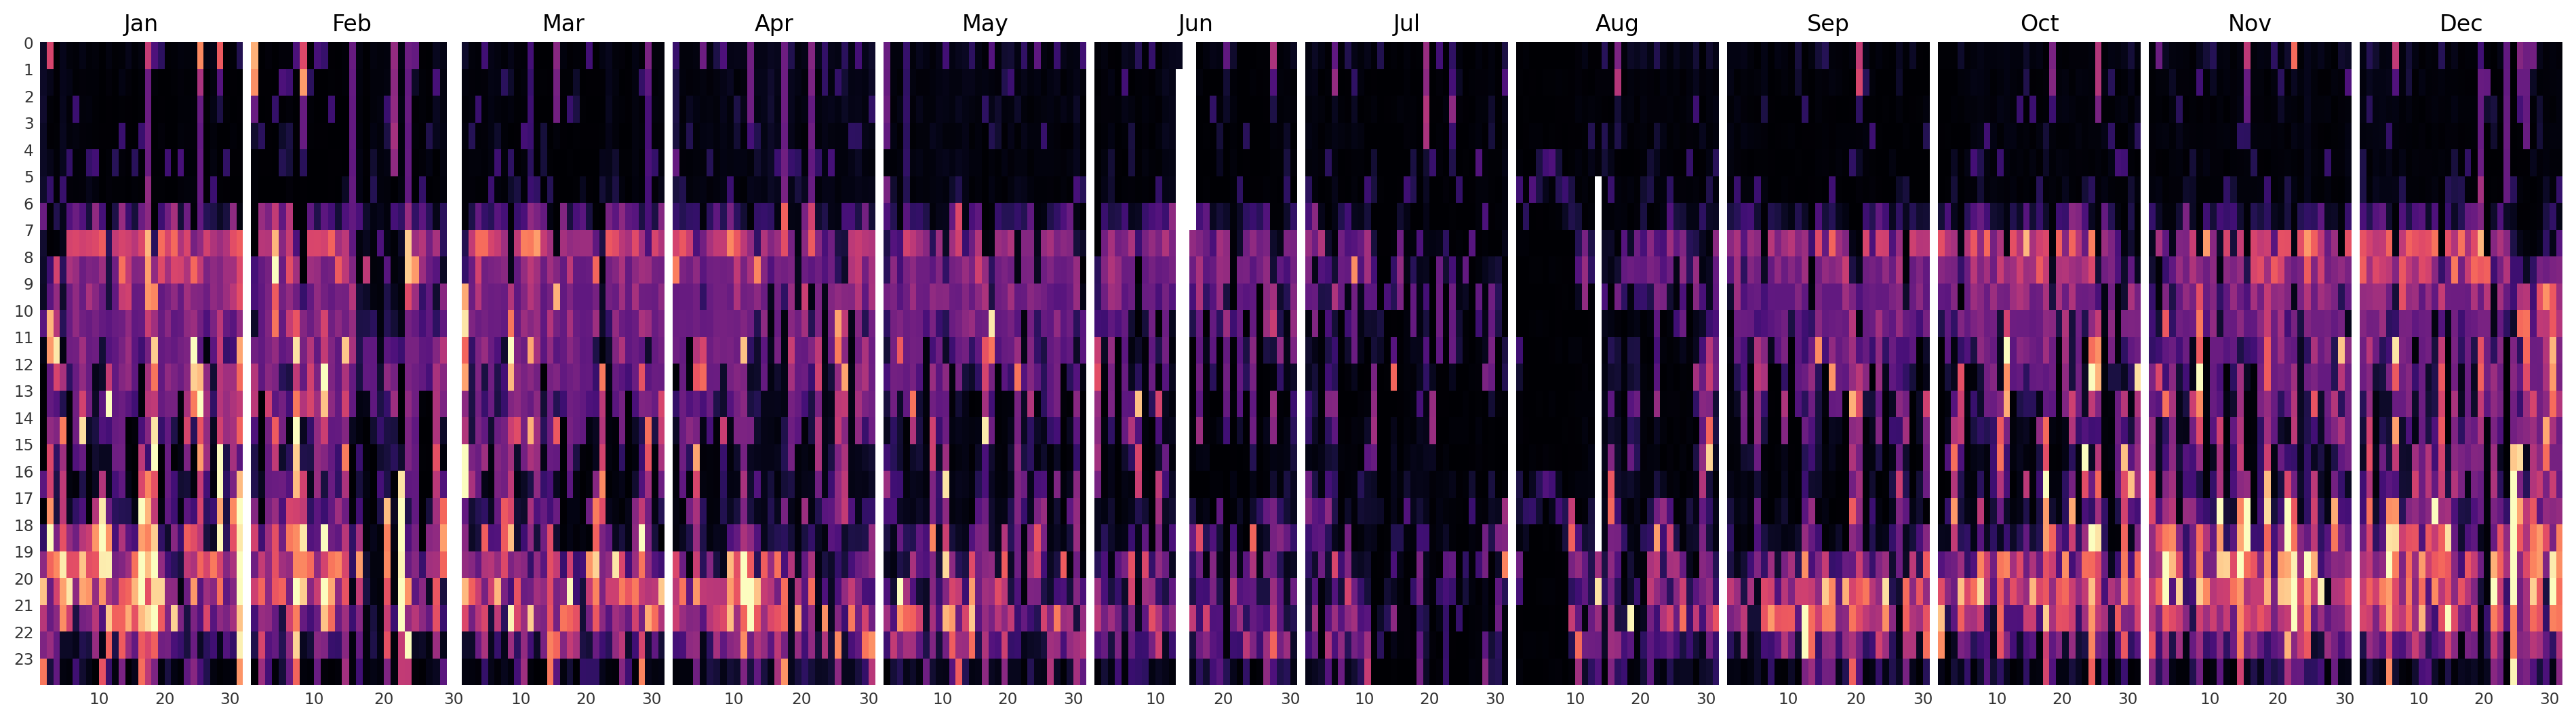

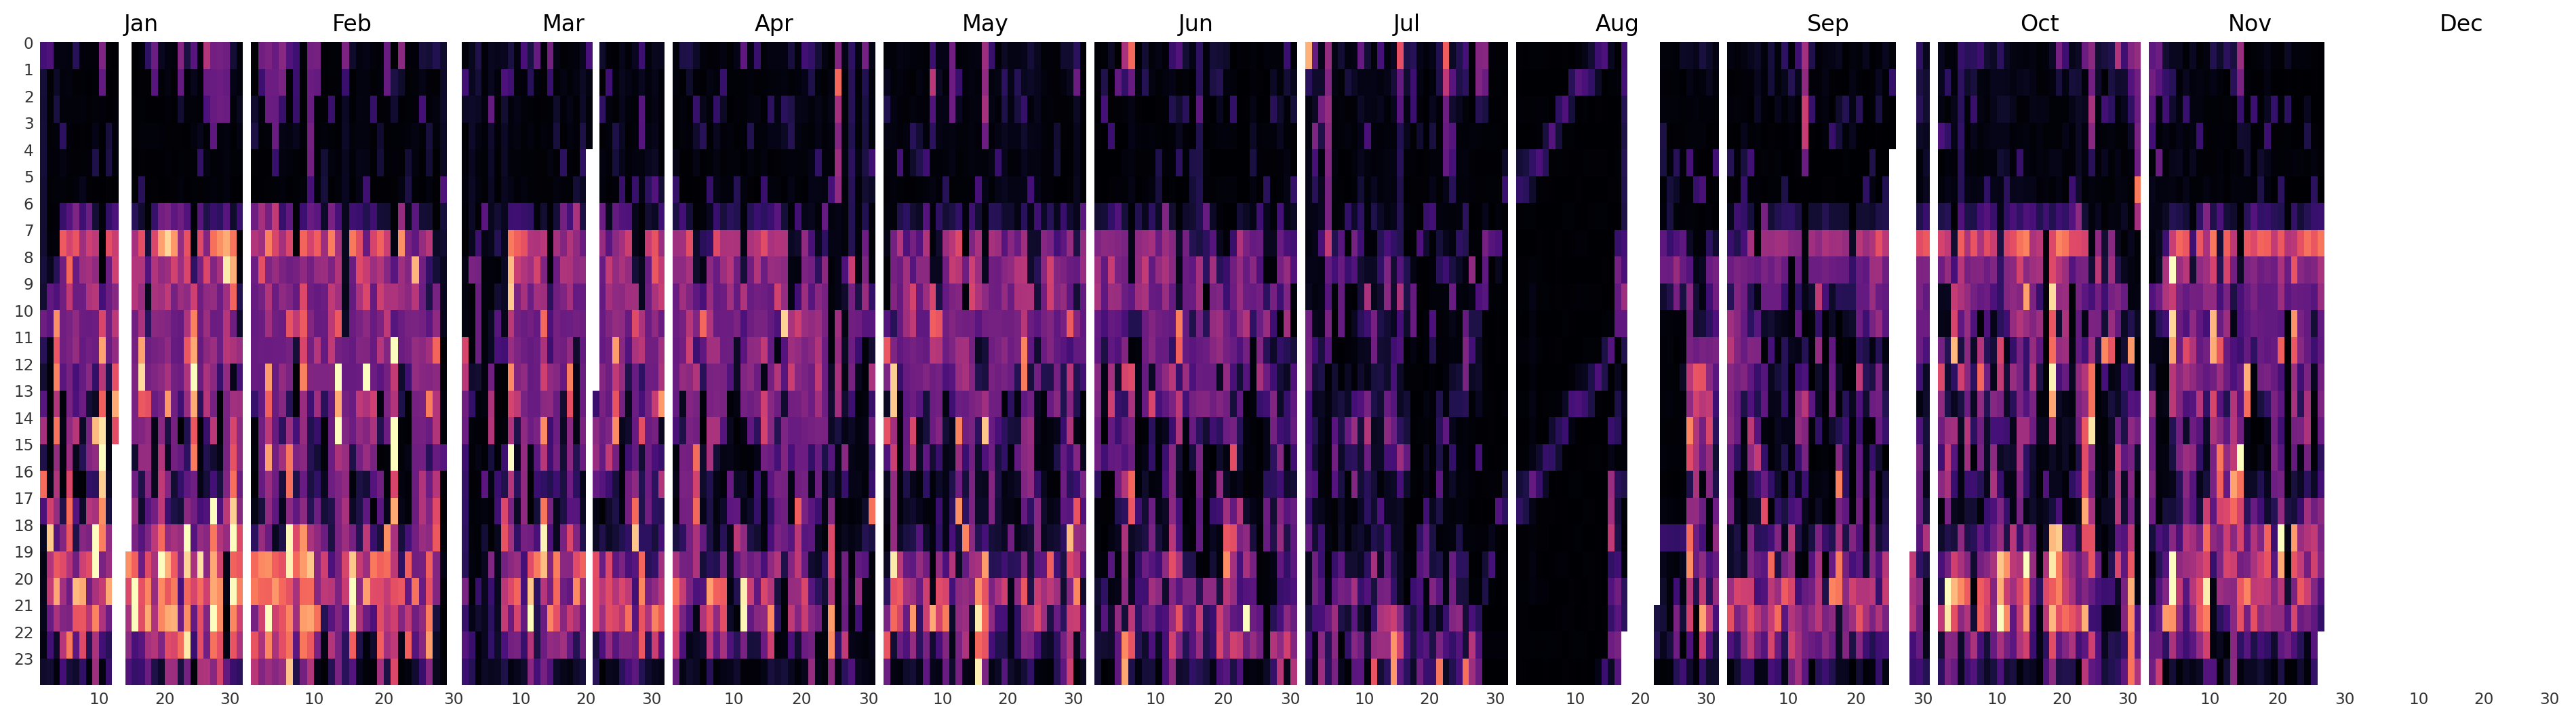

In [14]:
tmp = df
vmin, vmax = tmp.global_active_power.quantile(0.1), tmp.global_active_power.quantile(0.99)
key = 'global_active_power'

months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

for i, year in enumerate(tmp.timestamp.dt.year.unique()):
    fig, axes = plt.subplots(ncols=12, figsize=(20, 6), sharey=True)
    for j, month in enumerate(range(1, 13)):
        monthly_plot(tmp, key, month, year, axes[j], vmin, vmax)

        axes[j].set_title(months[j])

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)
    plt.show()

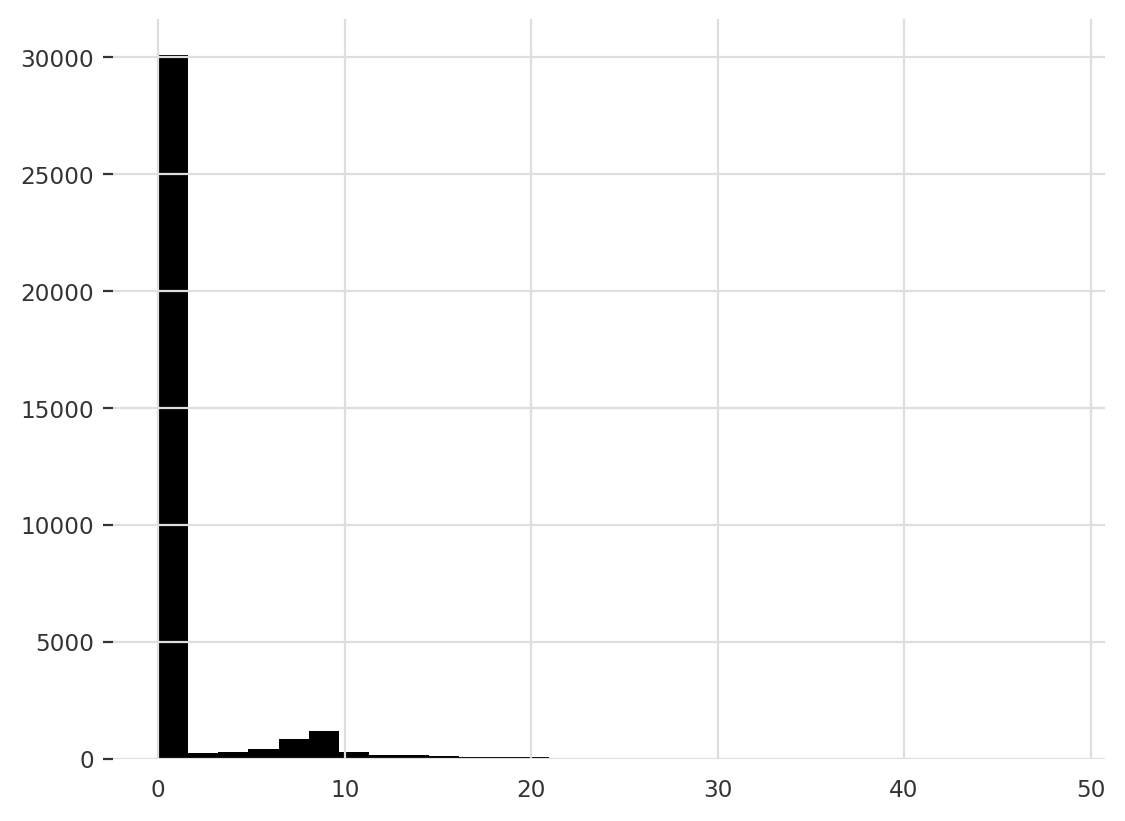

In [15]:
plt.hist(df['sub_metering_1'], bins=30);

In [16]:
# Design additional meta features
#first, last = [], []

# Somehow express the activity of the user. First and last active hour of the day
#firsts = df[df.sub_metering_1 > 0].groupby(df.timestamp.dt.date).nth(0)[['timestamp', 'sub_metering_1']]
#lasts = df[df.sub_metering_1 > 0].groupby(df.timestamp.dt.date).nth(-1)[['timestamp', 'sub_metering_1']]

# Social activities
df['kitchen_activity'] = df.sub_metering_1 > 0

# TODO: Proportion of energy consumed at current time based on Yesterday, last week.

# Energy spent today (don't use because it leaks data. Discard after done)
for _, group in df.groupby(df.timestamp.dt.date):
    daily_total = group['global_active_power'].sum()
    df.loc[group.index, 'daily_ratio'] = group['global_active_power'] / daily_total

    df.loc[group.index, 'today_median_energy'] = group['global_active_power'].median()

# energy consumption 1 day ago, 1 week ago
df['yesterday_ratio'] = df['daily_ratio'].shift(24)
df['yesterday_ahead_ratio'] = df['daily_ratio'].shift(24 - 1)
df['last_week_ratio'] = df['daily_ratio'].shift(24 * 7)

df['yesterday_median_energy'] = df['today_median_energy'].shift(24)

## Metadata

# energy percentage that was spent yesterday at this time

df.drop(columns=['daily_ratio', 'today_median_energy'], inplace=True)

In [17]:
#print(df[df.daily_ratio.isna()].count())
df.tail(5).T

timestamp,2010-11-26 17:00:00,2010-11-26 18:00:00,2010-11-26 19:00:00,2010-11-26 20:00:00,2010-11-26 21:00:00
global_active_power,28.765,26.224444,27.655556,19.395,15.577778
global_reactive_power,1.023333,0.895,1.000556,1.019444,0.0
sub_metering_1,0.0,0.0,0.0,0.0,0.0
sub_metering_2,0.0,0.0,0.066667,1.066667,0.0
sub_metering_3,12.866667,0.0,0.0,0.0,0.0
unmetered,15.898333,26.224444,27.588889,18.328333,15.577778
voltage,237.069667,237.531833,236.741,239.396,239.69
global_intensity,7.216667,6.62,7.056667,4.913333,3.8
country,France,France,France,France,France
region,Sceaux,Sceaux,Sceaux,Sceaux,Sceaux


In [18]:
ts_columns = df.columns.to_list()[:8]
ts_columns

['global_active_power',
 'global_reactive_power',
 'sub_metering_1',
 'sub_metering_2',
 'sub_metering_3',
 'unmetered',
 'voltage',
 'global_intensity']

In [19]:
df['prediction'] = df['global_active_power'].shift(-1) / 1000.0 # Convert Wh --> kWh

for col in ts_columns:
    df[f'{col}_mean_3h'] = df[col].rolling(3).mean()
    df[f'{col}_std_3h'] = df[col].rolling(3).std()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(3).T

,0,1,2
global_active_power,90.875556,64.656667,68.630556
global_reactive_power,3.599444,1.662778,3.422222
sub_metering_1,16.183333,0.0,0.0
sub_metering_2,0.666667,0.016667,0.6
sub_metering_3,16.75,17.35,17.466667
unmetered,57.275556,47.29,50.563889
voltage,233.644167,238.0005,238.729333
global_intensity,23.36,16.363333,17.3
country,France,France,France
region,Sceaux,Sceaux,Sceaux


In [20]:
domain_features = []
for name in df.columns.to_list():
    if ('power' in name) or ('meter' in name) or ('volt' in name) or ('intensity' in name):
        domain_features.append(name)

assert len(domain_features) == 24
print(f'{domain_features=}')

contextual_features = []
for name in df.columns.to_list():
    if name.startswith('solar_') or name.startswith('year_') or name.startswith('day_') or name.startswith('week_'):
        contextual_features.append(name)

assert len(contextual_features) == 6
print(f'{contextual_features=}')

behavioral_features = ['weekday', 'is_holiday', 'is_weekend', 'kitchen_activity', 'yesterday_ratio', 'yesterday_ahead_ratio', 'last_week_ratio', 'yesterday_median_energy']
print(f'{behavioral_features=}')

set(df.columns) - set(domain_features + contextual_features + behavioral_features + ["tz", 'region', "country", "timestamp"] + ['prediction'])

domain_features=['global_active_power', 'global_reactive_power', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3', 'unmetered', 'voltage', 'global_intensity', 'global_active_power_mean_3h', 'global_active_power_std_3h', 'global_reactive_power_mean_3h', 'global_reactive_power_std_3h', 'sub_metering_1_mean_3h', 'sub_metering_1_std_3h', 'sub_metering_2_mean_3h', 'sub_metering_2_std_3h', 'sub_metering_3_mean_3h', 'sub_metering_3_std_3h', 'unmetered_mean_3h', 'unmetered_std_3h', 'voltage_mean_3h', 'voltage_std_3h', 'global_intensity_mean_3h', 'global_intensity_std_3h']
contextual_features=['day_percent', 'week_percent', 'year_percent', 'solar_altitude', 'solar_azimuth', 'solar_radiation']
behavioral_features=['weekday', 'is_holiday', 'is_weekend', 'kitchen_activity', 'yesterday_ratio', 'yesterday_ahead_ratio', 'last_week_ratio', 'yesterday_median_energy']


{'lat', 'lon'}

In [21]:
weekday_categories = [sorted(list(df.weekday.unique()))]

mapper = DataFrameMapper(
    [
        (["weekday"], preprocessing.OneHotEncoder(categories=weekday_categories, sparse=False)),
    ],
    default=None,
    input_df=True,
    df_out=True,
    drop_cols=["tz", 'region', "country", "timestamp"],
)

regressor = pipeline.make_pipeline(
    mapper,
    xgb.XGBRegressor(n_jobs=-1, random_state=42),
    #linear_model.LinearRegression(n_jobs=-1),
    verbose=True
)

X, y = df.drop(columns=['prediction']), df['prediction']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X[domain_features + contextual_features + behavioral_features], y, train_size=0.8, shuffle=False)

y_pred = regressor.fit(X_train, y_train).predict(X_test)

mape = metrics.mean_absolute_percentage_error(y_test + 1e-6, y_pred + 1e-6)
mse = metrics.mean_squared_error(y_test, y_pred)

print(f'{mape=}; {mse=}')

/home/gcerar/miniconda3/envs/energy-graph/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[Pipeline] ... (step 1 of 2) Processing dataframemapper, total=   0.1s
[Pipeline] ...... (step 2 of 2) Processing xgbregressor, total=   1.1s
mape=0.40961654222210103; mse=6.255519024952998e-05


/home/gcerar/miniconda3/envs/energy-graph/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
dfp = df.copy()
dfp.rename(columns=dict(timestamp='ds', prediction='y'), inplace=True)
#print(dfp.info())
dfp_train, dfp_test = model_selection.train_test_split(dfp, train_size=0.8, shuffle=False)

#print(dfp_train.columns)
m = Prophet()

m.add_country_holidays(country_name='France')
for f in domain_features + contextual_features + behavioral_features:
    #print(f)
    m.add_regressor(f)

forecast = m.fit(dfp_train).predict(dfp_test)

mape = metrics.mean_absolute_percentage_error(dfp_test[['y']] + 1e-6, forecast[['yhat']] + 1e-6)
mse = metrics.mean_squared_error(dfp_test[['y']], forecast[['yhat']])

print(f'{mape=} {mse=}')

16:19:46 - cmdstanpy - INFO - Chain [1] start processing
16:19:50 - cmdstanpy - INFO - Chain [1] done processing


mape=0.46912410828803996 mse=6.829636679098673e-05


In [23]:
forecast.head(3).T

,0,1,2
ds,2010-01-29 11:00:00,2010-01-29 12:00:00,2010-01-29 13:00:00
trend,0.017177,0.017177,0.017177
yhat_lower,0.026773,0.017066,0.012758
yhat_upper,0.050419,0.040304,0.036368
trend_lower,0.017177,0.017177,0.017177
...,...,...,...
yesterday_ratio_upper,0.000013,0.000228,0.000537
multiplicative_terms,0.0,0.0,0.0
multiplicative_terms_lower,0.0,0.0,0.0
multiplicative_terms_upper,0.0,0.0,0.0


In [11]:

df_train, df_test = model_selection.train_test_split(df, train_size=0.8, shuffle=False)

series_train = TimeSeries.from_dataframe(df_train, 'timestamp', 'global_active_power', fill_missing_dates=True, fillna_value=None, freq='H')
series_train = MissingValuesFiller().transform(series_train)

series_test = TimeSeries.from_dataframe(df_test, 'timestamp', 'global_active_power', freq='H')
series_test = MissingValuesFiller().transform(series_train)

m = AutoARIMA()

m.fit(series_train)

prediction = m.predict(len(series_test))

In [15]:
#from darts.metrics import mape as darts_mape, mse as darts_mse

y_pred = prediction['global_active_power'].values()
y_true = series_test['global_active_power'].values()

mape = metrics.mean_absolute_percentage_error(y_true + 1e-6, y_pred + 1e-6)
#mse = darts_mse(y_true, y_pred, n_jobs=-1)
mse = metrics.mean_squared_error(y_true, y_pred)

print(f'{mape=} {mse=}')

mape=1.165315571210021 mse=323.1909615756396


In [22]:
df_train, df_test = model_selection.train_test_split(df, train_size=0.8, shuffle=False)

features = domain_features + contextual_features + behavioral_features

series_train = TimeSeries.from_dataframe(df_train, 'timestamp', features, fill_missing_dates=True, fillna_value=None, freq='H')
series_train = MissingValuesFiller().transform(series_train)

series_test = TimeSeries.from_dataframe(df_test, 'timestamp', features, freq='H')
series_test = MissingValuesFiller().transform(series_train)


m = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
    random_state=42,
    pl_trainer_kwargs=dict(accelerator='gpu', devices=1),
)

m.fit(series=series_train, val_series=series_test)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 39.2 M
---------------------------------------------------
39.2 M    Trainable params
8.5 K     Non-trainable params
39.2 M    Total params
313.876   Total estimated model params size (MB)


Epoch 99: 100%|██████████| 70/70 [00:25<00:00,  2.71it/s, loss=48.7, train_loss=103.0, val_loss=57.20]   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 70/70 [00:25<00:00,  2.71it/s, loss=48.7, train_loss=103.0, val_loss=57.20]


In [23]:
prediction = m.predict(len(series_test))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:16<00:00, 16.46s/it]


In [24]:
y_pred = prediction['global_active_power'].values()
y_true = series_test['global_active_power'].values()

mape = metrics.mean_absolute_percentage_error(y_true + 1e-6, y_pred + 1e-6)
#mse = darts_mse(y_true, y_pred, n_jobs=-1)
mse = metrics.mean_squared_error(y_true, y_pred)

print(f'{mape=} {mse=}')

mape=5.236366267343366 mse=2239.0414598772722


In [116]:
# HUE dataset

In [117]:
df = pd.read_parquet('../data/hue-dataset-hourly.parquet')

#df.dropna(inplace=True)
#df.reset_index(drop=True, inplace=True)

df['energy'] = df['energy'] / 1000.0 # convert Wh --> kWh

df['house_activity'] = False

for _, group in df.groupby(by='residential_id'):
    group = group.sort_values(by='timestamp')

    for col in ['energy']:
        df.loc[group.index, f'{col}_mean_3h'] = group[col].rolling(3).mean()
        df.loc[group.index, f'{col}_std_3h'] = group[col].rolling(3).std()

    df.loc[group.index, 'prediction'] = group['energy'].shift(-1)


    # Energy spent today (don't use because it leaks data. Discard after done.)
    for _, subgroup in df.groupby(group.timestamp.dt.date):
        df.loc[subgroup.index, 'daily_ratio'] = subgroup['energy'] / subgroup['energy'].sum()

        df.loc[subgroup.index, 'today_median_energy'] = subgroup['energy'].median()

    
    # energy consumption 1 day ago, 1 week ago
    df.loc[group.index,'yesterday_ratio'] = df.loc[group.index,'daily_ratio'].shift(24)
    df.loc[group.index,'yesterday_ahead_ratio'] = df.loc[group.index,'daily_ratio'].shift(24 - 1)

    df.loc[group.index,'last_week_ratio'] = df.loc[group.index,'daily_ratio'].shift(24 * 7)
    df.loc[group.index,'last_week_ahead_ratio'] = df.loc[group.index,'daily_ratio'].shift(24 * 7 - 1)


    # Estimate activity through median value of the time-series
    #group['house_activity'] = group.energy >= group.energy.median()
    df.loc[group.index, 'yesterday_median_energy'] = df.loc[group.index, 'today_median_energy'].shift(24)

    df.loc[group.index, 'energy_yesterday'] = group['energy'].shift(24)
    df.loc[group.index, 'energy_yesterday_ahead'] = group['energy'].shift(24 - 1)

    df.loc[group.index, 'house_activity'] = df.loc[group.index, 'energy'] >= df.loc[group.index, 'yesterday_median_energy']


# df_train, df_test = [], []
# for _, group in df.groupby(by='residential_id'):
#     group = group.sort_values(by='timestamp')

#     for col in ['energy']:
#         group[f'{col}_mean_3h'] = group[col].rolling(3).mean()
#         group[f'{col}_std_3h'] = group[col].rolling(3).std()

#     group['prediction'] = group['energy'].shift(-1)

#     # Estimate activity through median value of the time-series
#     group['activity'] = group.energy >= group.energy.median()

#     # TODO: Po uri procentualna poraba v dnevu ...

#     group.dropna(inplace=True)

#     train, test = model_selection.train_test_split(group, train_size=0.8, shuffle=False)
    
#     df_train.append(train)
#     df_test.append(test)

df.drop(columns=['daily_ratio', 'today_median_energy'], inplace=True)


In [118]:

df.tail(25)

,residential_id,timestamp,energy,house_type,facing,region,RUs,EVs,SN,FAGF,...,energy_mean_3h,energy_std_3h,prediction,yesterday_ratio,yesterday_ahead_ratio,last_week_ratio,last_week_ahead_ratio,yesterday_median_energy,energy_yesterday,energy_yesterday_ahead
616030,8,2018-02-19 23:00:00,0.23,character,S,YVR,0.0,0.0,0.0,1,...,0.406667,0.175024,0.23,0.020846,0.037919,0.063521,0.014667,0.435,0.35,0.43
616031,8,2018-02-20 00:00:00,0.23,character,S,YVR,0.0,0.0,0.0,1,...,0.290000,0.103923,0.20,0.037919,0.072310,0.014667,0.016000,0.420,0.43,0.82
616032,8,2018-02-20 01:00:00,0.20,character,S,YVR,0.0,0.0,0.0,1,...,0.220000,0.017321,0.41,0.072310,0.019400,0.016000,0.013333,0.420,0.82,0.22
616033,8,2018-02-20 02:00:00,0.41,character,S,YVR,0.0,0.0,0.0,1,...,0.280000,0.113578,0.66,0.019400,0.018519,0.013333,0.020667,0.420,0.22,0.21
616034,8,2018-02-20 03:00:00,0.66,character,S,YVR,0.0,0.0,0.0,1,...,0.423333,0.230290,0.42,0.018519,0.031746,0.020667,0.016667,0.420,0.21,0.36
616035,8,2018-02-20 04:00:00,0.42,character,S,YVR,0.0,0.0,0.0,1,...,0.496667,0.141539,0.31,0.031746,0.027337,0.016667,0.024667,0.420,0.36,0.31
616036,8,2018-02-20 05:00:00,0.31,character,S,YVR,0.0,0.0,0.0,1,...,0.463333,0.178979,0.61,0.027337,0.044092,0.024667,0.043333,0.420,0.31,0.50
616037,8,2018-02-20 06:00:00,0.61,character,S,YVR,0.0,0.0,0.0,1,...,0.446667,0.151767,1.86,0.044092,0.062610,0.043333,0.071333,0.420,0.50,0.71
616038,8,2018-02-20 07:00:00,1.86,character,S,YVR,0.0,0.0,0.0,1,...,0.926667,0.822091,0.71,0.062610,0.042328,0.071333,0.054000,0.420,0.71,0.48
616039,8,2018-02-20 08:00:00,0.71,character,S,YVR,0.0,0.0,0.0,1,...,1.060000,0.694622,0.26,0.042328,0.063492,0.054000,0.069333,0.420,0.48,0.72


In [119]:
domain_features = ['EVs'] + [c for c in df.columns if c.startswith('energy')]
contextual_features = [
    'residential_id', 'house_type', 'facing', 'region', 'RUs', 'SN', 'FAGF', 'HP', 'FPG', 'FPE', 'IFRHG',
    'NAC', 'FAC', 'PAC', 'BHE', 'IFRHE', 'WRHIR', 'GEOTH', 'country', 'lat', 'lon', 'tz', 'temperature', 'humidity', 'pressure',
    'day_percent', 'week_percent', 'year_percent', 'solar_altitude', 'solar_azimuth', 'solar_radiation'
]
behavioral_features = ['weekday', 'is_weekend', 'is_holiday', 'house_activity', 'yesterday_ratio', 'yesterday_ahead_ratio', 'last_week_ratio', 'last_week_ahead_ratio', 'yesterday_median_energy']

set(df.columns) - set(domain_features + contextual_features + behavioral_features)

{'prediction', 'timestamp'}

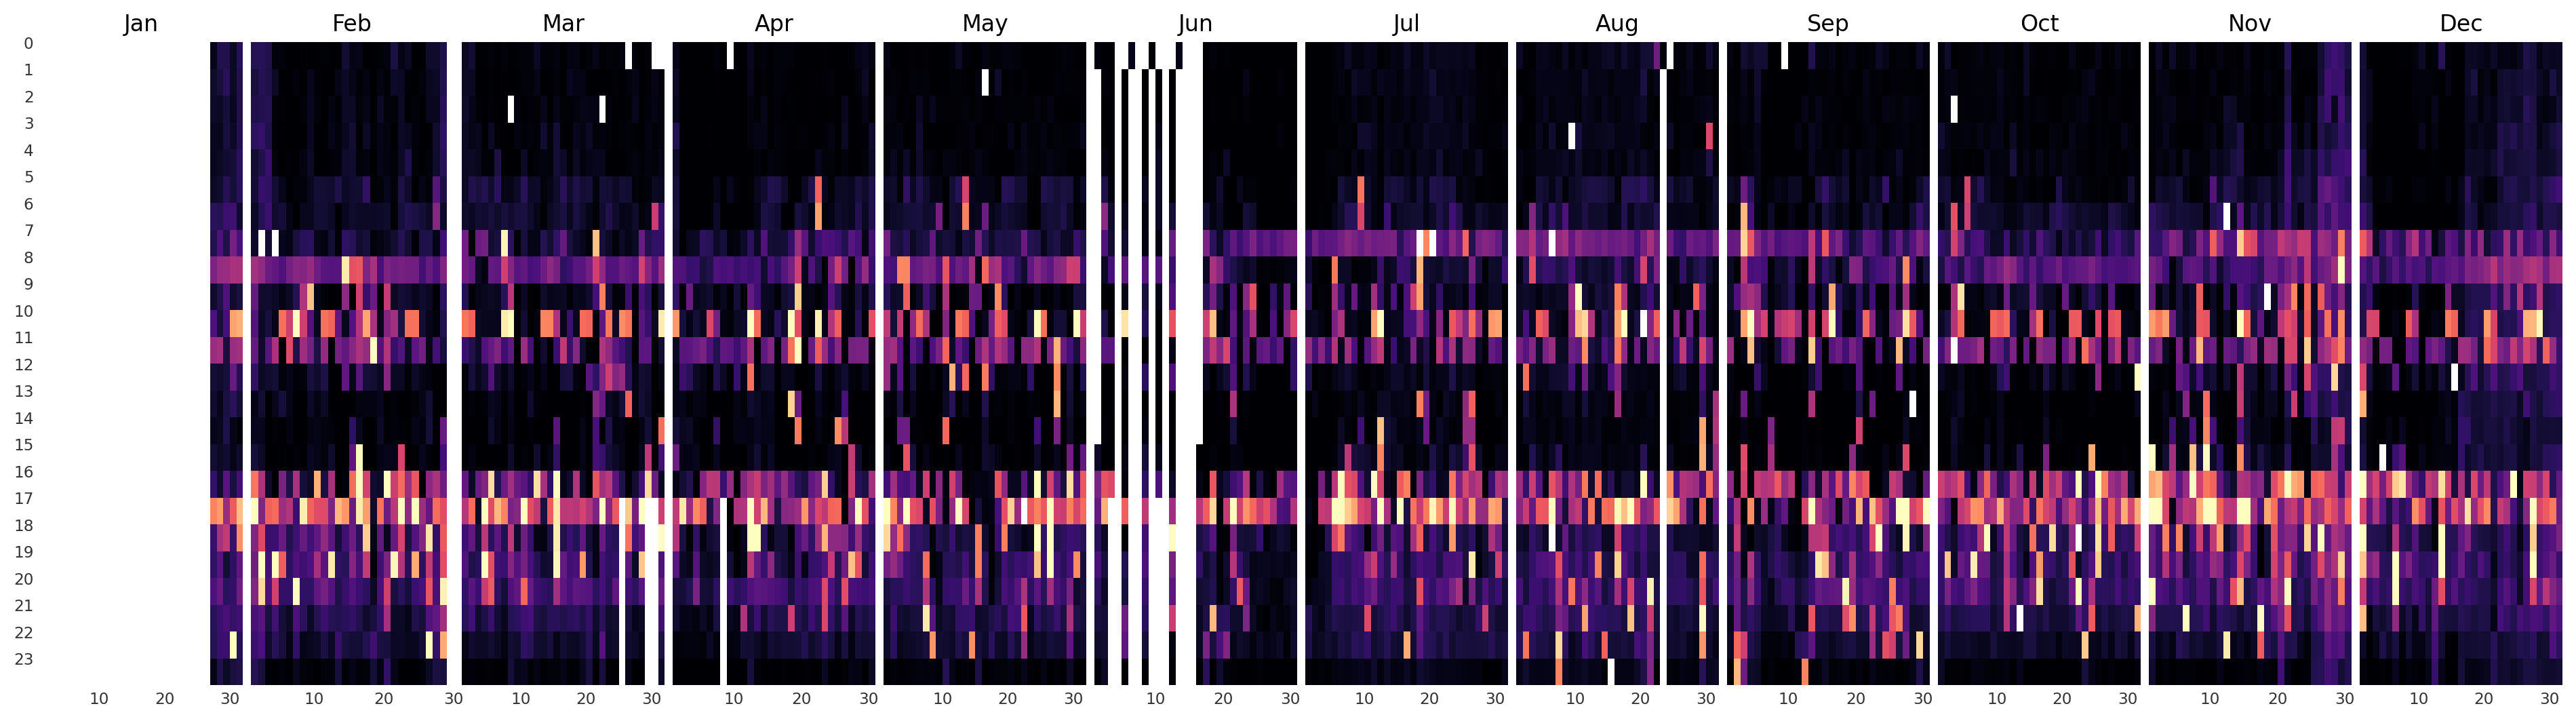

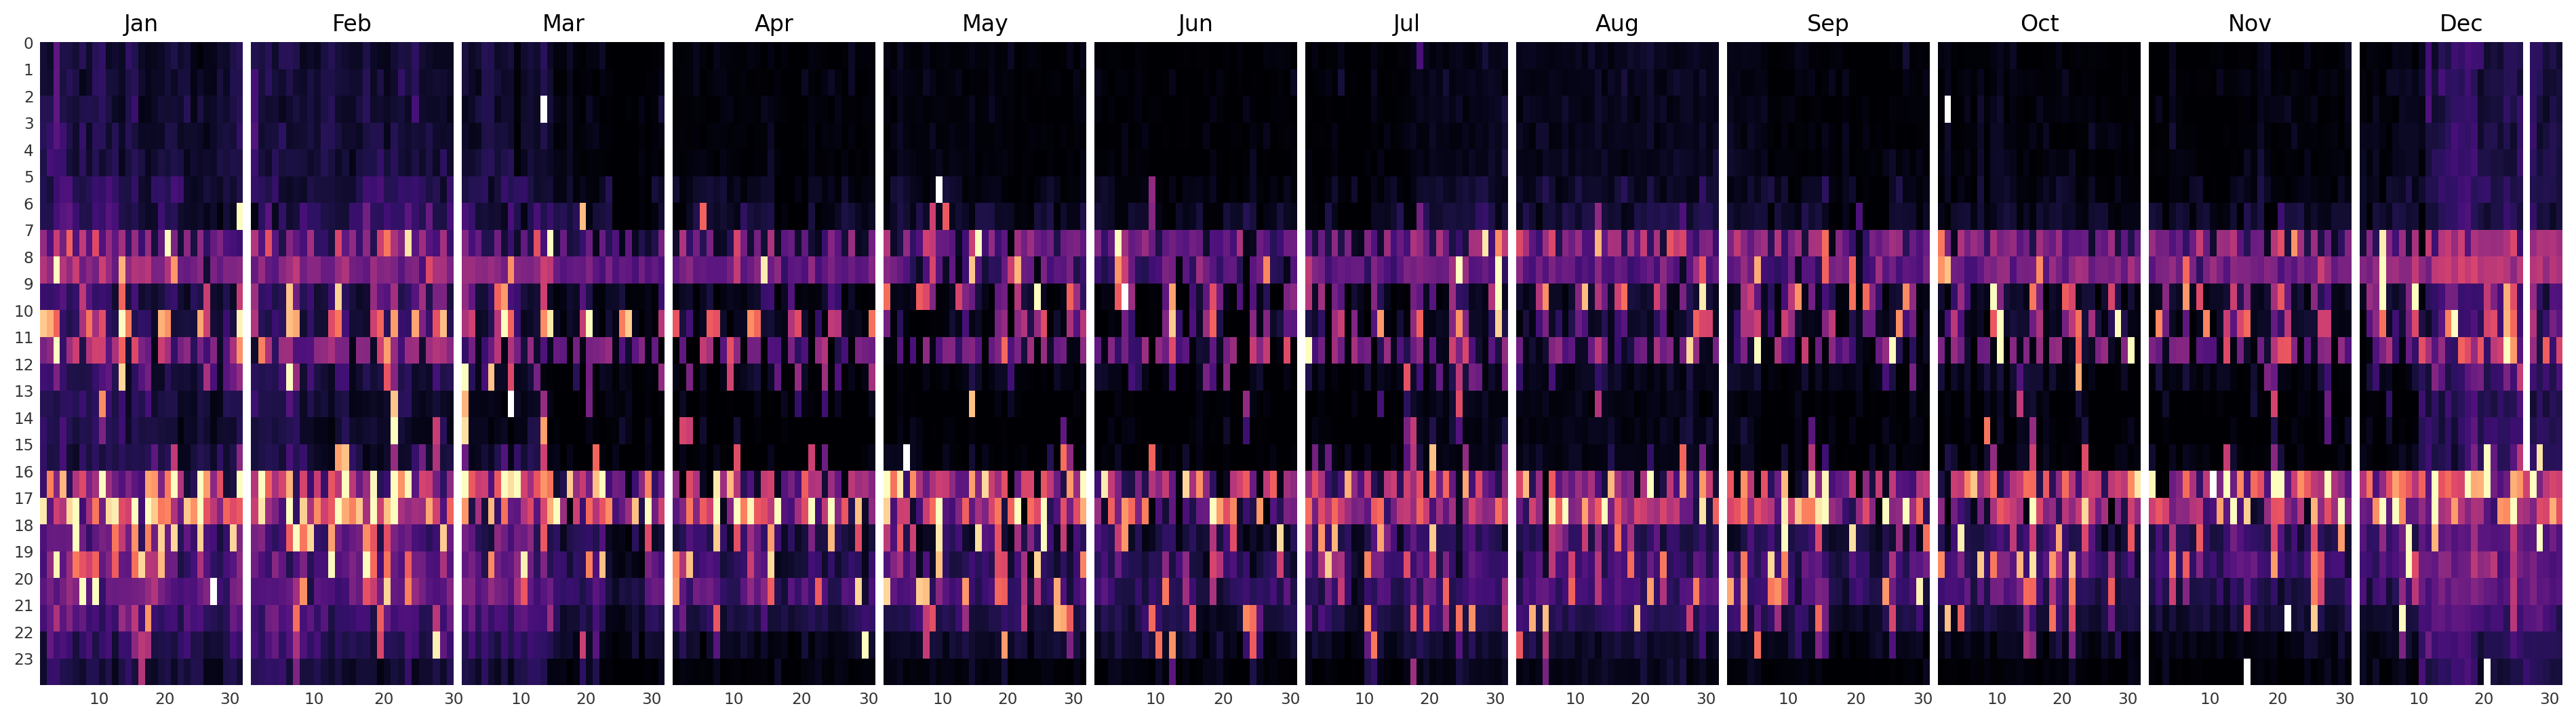

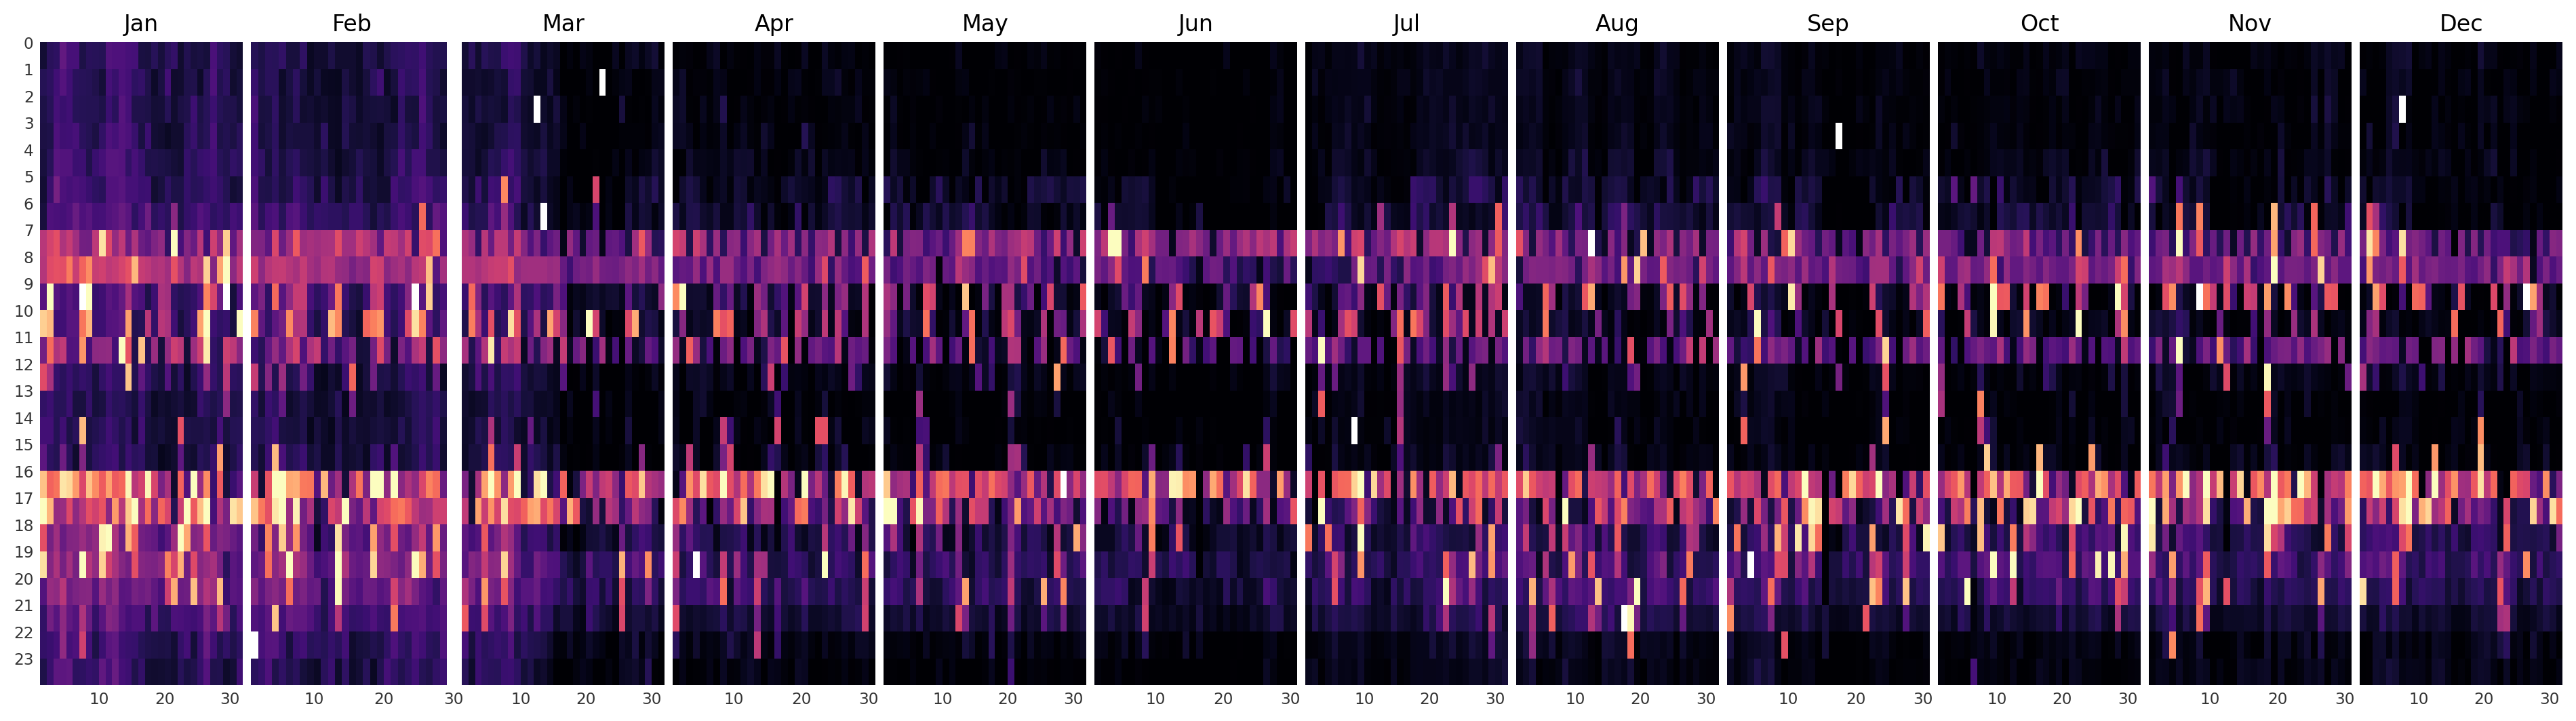

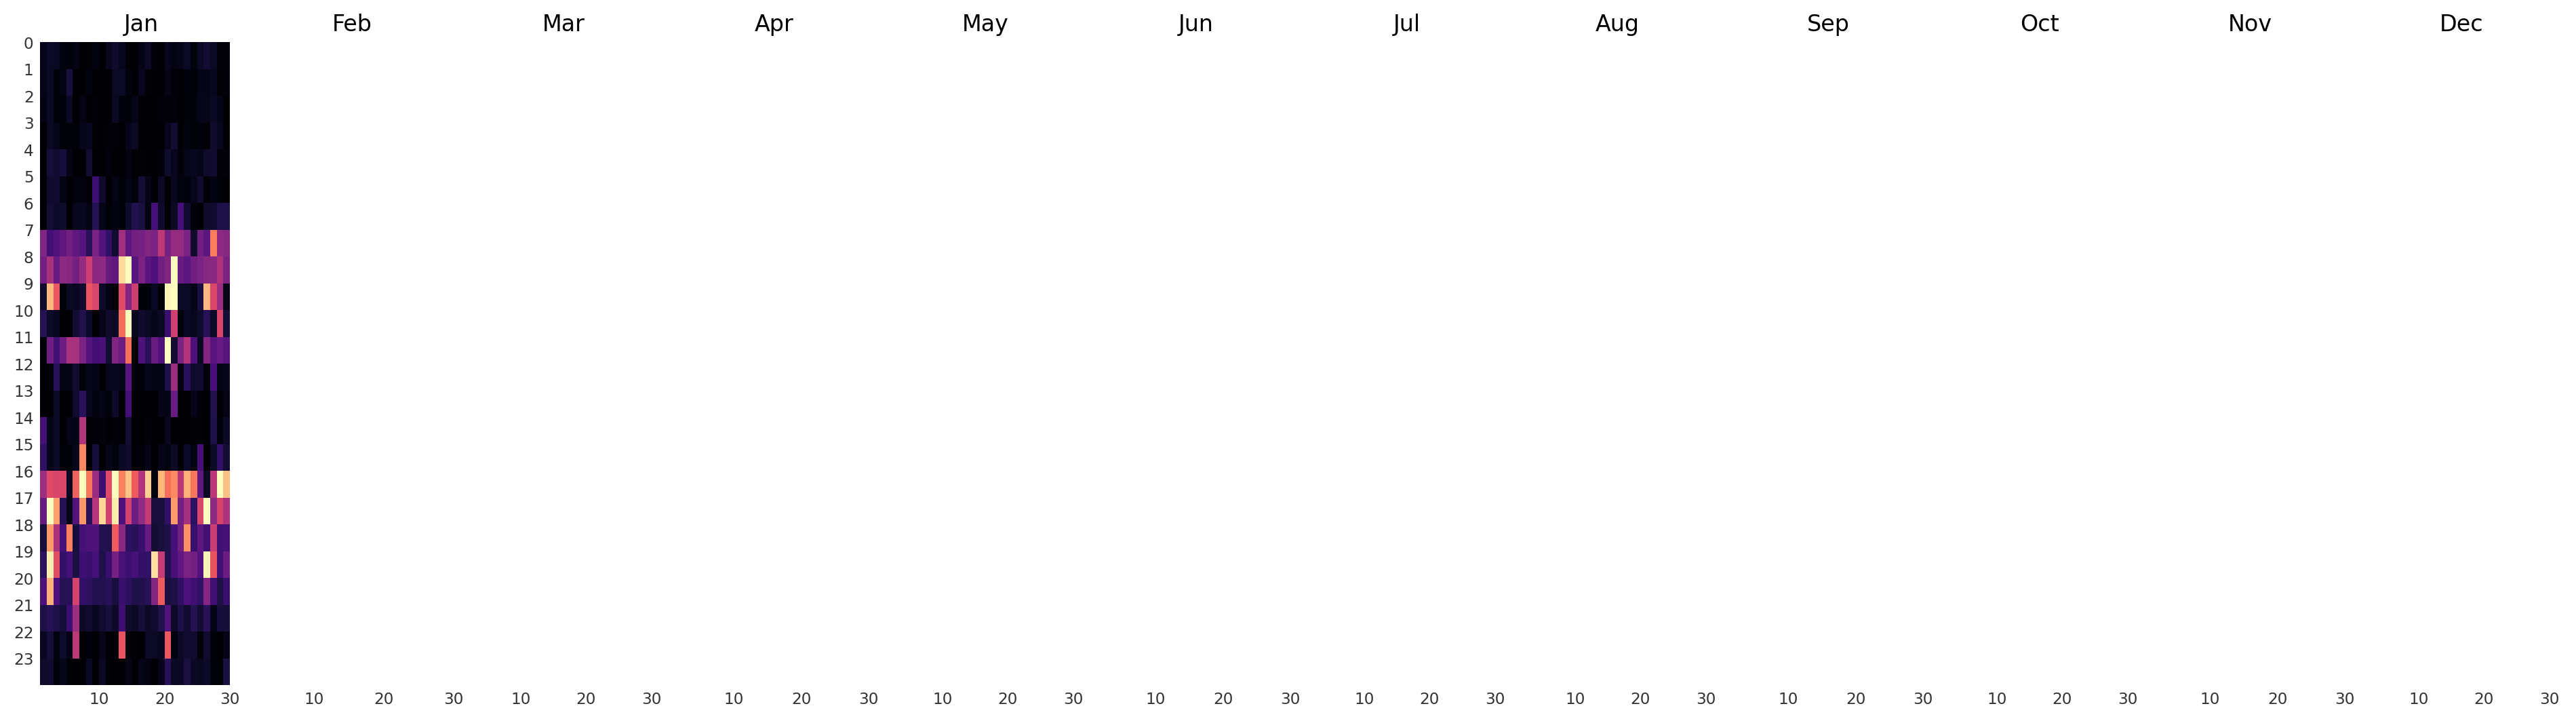

In [120]:
def monthly_plot(data: pd.DataFrame, month:int, year:int, ax, vmin:float=None, vmax:float=None):
    data = data.set_index('timestamp')

    data = data[['energy']].resample('1H').mean()
    
    new_index = pd.date_range(start=f'{data.index.year.min()}-01-01T00:00', end=f'{data.index.year.max()+1}-01-01T00:00', freq='1H')
    data = data.reindex(new_index)

    data = data[(data.index.year == year) & (data.index.month == month)]

    hour = data.index.hour
    day = data.index.day
    series = data.energy
    series = series.values.reshape(24, len(day.unique()), order="F")
    
    xgrid = np.arange(day.max() + 1) + 1
    ygrid = np.arange(25)
    
    ax.grid(False)

    ax.pcolormesh(xgrid, ygrid, series, cmap="magma", vmin=vmin, vmax=vmax)
    # Invert the vertical axis
    ax.set_ylim(24, 0)
    # Set tick positions for both axes
    ax.yaxis.set_ticks([i for i in range(24)])
    ax.xaxis.set_ticks([10, 20, 30])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.xaxis.set_tick_params(which='both', length=0)
    
    # Remove all spines
    ax.set_frame_on(False)
    

    #ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    #ax.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=True)


tmp = df[(df.residential_id == 3)]
vmin, vmax = tmp.energy.quantile(0.1), tmp.energy.quantile(0.99)

months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

for i, year in enumerate(tmp.timestamp.dt.year.unique()):
    fig, axes = plt.subplots(ncols=12, figsize=(20, 6), sharey=True)
    for j, month in enumerate(range(1, 13)):
        monthly_plot(tmp, month, year, axes[j], vmin, vmax)

        axes[j].set_title(months[j])

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)
    plt.show()

In [124]:
mapper = DataFrameMapper(
    [
        (["weekday"], preprocessing.OneHotEncoder(categories=[sorted(df.weekday.unique())], sparse=False)),
        (["house_type"], preprocessing.OneHotEncoder(categories=[sorted(df.house_type.unique())], sparse=False)),
        (["facing"], preprocessing.OneHotEncoder(categories=[sorted(df.facing.unique())], sparse=False)),
        (["region"], preprocessing.OneHotEncoder(categories=[sorted(df.region.unique())], sparse=False)),
    ],
    default=None,
    input_df=True,
    df_out=True,
    drop_cols=["tz", "country", "timestamp", 'validation', 'prediction'],
)

regressor = pipeline.make_pipeline(
    mapper,
    xgb.XGBRegressor(n_jobs=-1, random_state=42),
    #linear_model.LinearRegression(n_jobs=-1),
    verbose=True
)

features = domain_features + contextual_features + behavioral_features

df['validation'] = False

for _, group in df.groupby(by='residential_id'): 
    size = int(len(group) * 0.80)
    df.loc[group.iloc[size:].index, 'validation'] = True


train, test = df[~df.validation].dropna(), df[df.validation].dropna()


X_train, y_train = train.drop(columns=['prediction']), train['prediction']
X_test, y_test = test.drop(columns=['prediction']), test['prediction']

regressor.fit(X_train[features], y_train)
y_pred = regressor.predict(X_test[features])


#df_train, df_test = pd.concat(df_train, ignore_index=True), pd.concat(df_test, ignore_index=True)
#dataset = pd.concat([df_train, df_test], ignore_index=True)
#X, y = dataset.drop(columns=['prediction']), dataset['prediction']

#y_pred = model_selection.cross_val_predict(regressor, X[features], y, cv=10)
#X_test, y_true = df_test.drop(columns=['prediction']), df_test['prediction']

#y_pred = regressor.fit(X_train[features], y_train).predict(X_test[features])


# y_pred = []
# y_true = []

# # Train per-household model
# for train, test in zip(df_train, df_test):

#     X_train, y_train = train.drop(columns=['prediction']), train['prediction']
#     X_test, y_test = test.drop(columns=['prediction']), test['prediction']


#     _y_pred = regressor.fit(X_train[features], y_train).predict(X_test[features])

#     y_pred.append(_y_pred)
#     y_true.append(y_test)

# y_pred = np.concatenate(y_pred, axis=0)
# y_true = np.concatenate(y_true, axis=0)

mape = metrics.mean_absolute_percentage_error(y_test + 1e-3, y_pred + 1e-3)
mse = metrics.mean_squared_error(y_test, y_pred)

print(f'{mape=}; {mse=}')

/home/gcerar/miniconda3/envs/energy-graph/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/gcerar/miniconda3/envs/energy-graph/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/gcerar/miniconda3/envs/energy-graph/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/gcerar/miniconda3/envs/energy-graph/lib/python3.8/si

[Pipeline] ... (step 1 of 2) Processing dataframemapper, total=   7.9s
[Pipeline] ...... (step 2 of 2) Processing xgbregressor, total=  13.9s


/home/gcerar/miniconda3/envs/energy-graph/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/gcerar/miniconda3/envs/energy-graph/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/gcerar/miniconda3/envs/energy-graph/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/gcerar/miniconda3/envs/energy-graph/lib/python3.8/si

mape=0.5585126616311954; mse=0.3152745023763649


#